In [34]:
# Описание задания:
#
# А/А-тестирование мобильного приложения. 
# Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). 
# Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и 
# найти ее причины, если сплит-система действительно сломана.
# 
# Описание колонок:
#
#    experimentVariant – вариант эксперимента,
#    version – версия приложения,
#    purchase – факт покупки.
#
# Задача:
#
#    Запустите A/A-тест,
#    Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше,
#    Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (найдите аномалию в версии приложения),
#    Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста.

In [ ]:
# Импортируем необходимые библиотеки

import numpy as np
import pandas as pd
from scipy import stats
from tqdm.auto import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

In [35]:
# Считываем исходный датафрейм с данными:
# experimentVariant – вариант эксперимента,
# version – версия приложения,
# purchase – факт покупки

df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';')
df

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [36]:
# Определим количество строк и столбцов датафрейма

df.shape

(127018, 5)

In [37]:
# Посмотрим на типы данных в датафрейме

df.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [38]:
# Удалим лишний (дублирующий индексы) столбец датафрейма - "Unnamed: 0"

df = df.drop(columns=('Unnamed: 0')).rename(columns=({'experimentVariant':'experiment_variant'}))
df

,uid,experiment_variant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127013,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [39]:
# Определим количество наблюдений в каждой из выборок эксперимента
df.experiment_variant.value_counts()

1    63916
0    63102
Name: experiment_variant, dtype: int64

In [40]:
# Определим количество соответствующих версий мобильных приложений

df.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [41]:
df.head()

,uid,experiment_variant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [42]:
# Оценим наши экспериментальные группы на предмет конверсии и количества пользователей

df.groupby(['experiment_variant']).agg({'purchase': 'mean', 'version':'count'})

,purchase,version
experiment_variant,,
0,0.023945,63102
1,0.053242,63916


In [43]:
# Функция для проведения А/А-тестирования

def aa_testing(sample1, sample2, simulations = 2000, n_s=1000, a=0.05):

    res = []
    for i in tqdm(range(simulations)):
        s1 = sample1.sample(n_s, replace = False).values
        s2 = sample2.sample(n_s, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations")
    plt.show()
    
    return {'Number od simulations': simulations,
            'Sub sample size': n_s,
            'Alpha': a, 
            'FPR': sum(np.array(res) < a) / simulations}

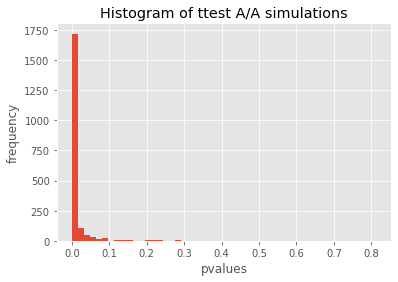

{'Number od simulations': 2000,
 'Sub sample size': 1000,
 'Alpha': 0.05,
 'FPR': 0.9355}

In [44]:
# Запускаем А/А тест

sample1 = df[df.experiment_variant == 1].purchase
sample2 = df[df.experiment_variant == 0].purchase
aa_testing(sample1, sample2)

In [45]:
# По результатам видно, что FPR получился высокий, что означает - количество значений "p-value" часто опускается ниже величины "0.05"

In [46]:
# Выведем отдельно для каждой версии мобильного приложения - количество конверсий и пользовательских установок

df.groupby(['experiment_variant', 'version']) \
    .agg({'purchase': 'mean', 'version':'count'}) \
    .rename(columns={'purchase':'conversion', 'version':'user_counts'})

conversion  user_counts
experiment_variant version                          
0                  v2.8.0      0.000993        41283
                   v2.9.0      0.074658        11921
                   v3.7.4.0    0.059943         4204
                   v3.8.0.0    0.057604         5694
1                  v2.8.0      0.045606        41552
                   v2.9.0      0.071304        12033
                   v3.7.4.0    0.063018         4221
                   v3.8.0.0    0.062848         6110

In [47]:
# Данные показывают, что в обоих вариантах эксперимента конверсия упала при переходе 
# с версий мобильного приложения - v2.9.0 на v3.7.4.0 и при переходе на версию - v3.8.0.0. 
# Самое наибольшее отличие наблюдается в версии - v2.8.0

In [48]:
# Произведем последовательно А/А тесты по всем экспериментальным группам

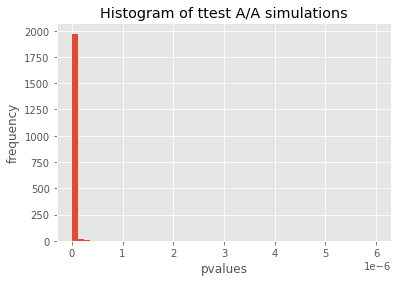

{'Number od simulations': 2000,
 'Sub sample size': 1000,
 'Alpha': 0.05,
 'FPR': 1.0}

In [49]:
s1 = df[df.experiment_variant == 0].query('version == "v2.8.0"').purchase
s2 = df[df.experiment_variant == 1].query('version == "v2.8.0"').purchase
aa_testing(s1, s2)

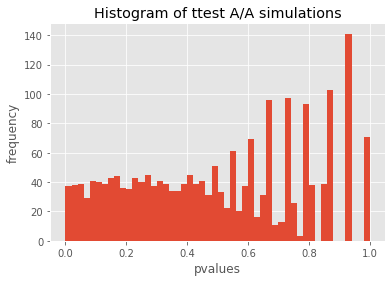

{'Number od simulations': 2000,
 'Sub sample size': 1000,
 'Alpha': 0.05,
 'FPR': 0.0475}

In [51]:
s1 = df[df.experiment_variant == 0].query('version == "v2.9.0"').purchase
s2 = df[df.experiment_variant == 1].query('version == "v2.9.0"').purchase
aa_testing(s1, s2)

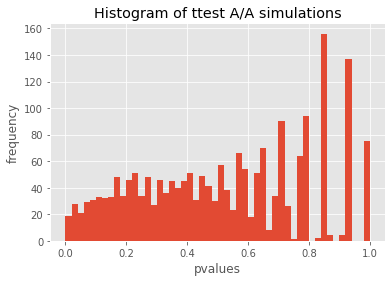

{'Number od simulations': 2000,
 'Sub sample size': 1000,
 'Alpha': 0.05,
 'FPR': 0.0285}

In [52]:
s1 = df[df.experiment_variant == 0].query('version == "v3.7.4.0"').purchase
s2 = df[df.experiment_variant == 1].query('version == "v3.7.4.0"').purchase
aa_testing(s1, s2)

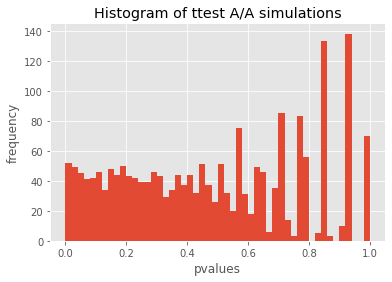

{'Number od simulations': 2000,
 'Sub sample size': 1000,
 'Alpha': 0.05,
 'FPR': 0.059}

In [53]:
s1 = df[df.experiment_variant == 0].query('version == "v3.8.0.0"').purchase
s2 = df[df.experiment_variant == 1].query('version == "v3.8.0.0"').purchase
aa_testing(s1, s2)

In [ ]:
# Здесь в результате мы видим высокий FPR по версии мобильного приложения v2.8.0

In [ ]:
# Теперь произведем А/А тест, исключая версию мобильного приложения v2.8.0

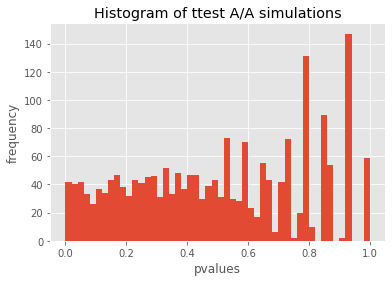

{'Number od simulations': 2000,
 'Sub sample size': 1000,
 'Alpha': 0.05,
 'FPR': 0.0495}

In [54]:
s1 = df[(df.experiment_variant == 0) & (df.version != 'v2.8.0')].purchase
s2 = df[(df.experiment_variant == 1) & (df.version != 'v2.8.0')].purchase
aa_testing(s1, s2)

In [ ]:
# Здесь мы видим, что по сравнению с первым тестом, в этом FPR ниже Alpha = 0.05, который мы приняли в нашем эксперименте

In [ ]:
# Основная поломка заключается в версии мобильного приложения. 
# В версии v2.8.0 - что-то сломалось, из за чего в разные группы А/А теста у нас попадают покупатели с сильно отличающейся конверсией.
# Эту группу следует исключить из дальнейших А/Б тестов, чтобы они не смещали общие оценки